## Mount Drive if your data is on it

In [8]:
colab_nb = 'google.colab' in str(get_ipython())
if colab_nb:
  from google.colab import drive
  drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [9]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import re
import sys
sys.path.append("../../util")

# PyTorch quantization supports only CPU
device = "cpu"

In [10]:
# Install these frameworks as they include modifications to enable model quantization

!pip install git+https://github.com/bassantmedhat/gen-efficientnet-pytorch.git
!pip install git+https://github.com/bassantmedhat/fastseg.git


  Cloning https://github.com/bassantmedhat/gen-efficientnet-pytorch.git to /tmp/pip-req-build-i5a62a24
  Running command git clone --filter=blob:none --quiet https://github.com/bassantmedhat/gen-efficientnet-pytorch.git /tmp/pip-req-build-i5a62a24
  Resolved https://github.com/bassantmedhat/gen-efficientnet-pytorch.git to commit 1e6f13a2f1ed5a741a1ce16e18e43e5ff30676a3
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/bassantmedhat/fastseg.git to /tmp/pip-req-build-v2n5uozx
  Running command git clone --filter=blob:none --quiet https://github.com/bassantmedhat/fastseg.git /tmp/pip-req-build-v2n5uozx
  Resolved https://github.com/bassantmedhat/fastseg.git to commit cf92833e55f90bdb29c1741b92171d7342ec306b
  Preparing metadata (setup.py) ... done


# Define Model

In [11]:
from fastseg import MobileV3Small
import torch
import torch.nn as nn

class MobileV3SmallWithSoftmax(nn.Module):
    def __init__(self, num_classes=3, use_aspp=True, num_filters=64):
        super(MobileV3SmallWithSoftmax, self).__init__()
        # Initialize the base MobileV3Small model
        self.model = MobileV3Small(num_classes=num_classes, use_aspp=use_aspp, num_filters=num_filters)

        # Define a Softmax layer for the final output
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Forward pass through the base model
        x = self.model(x)

        # Apply Softmax to the output
        x = self.softmax(x)

        return x


In [12]:
import torch
# load pretrained model to perform Quantization
model = MobileV3SmallWithSoftmax(num_classes=3, use_aspp=True, num_filters=64)
model.load_state_dict(torch.load('/content/drive/MyDrive/final_TRAINED_model.pth',map_location = "cpu"))
model = model.to(device)




#Building Training & Testing Pipeline


In [13]:
# some other usefuls libs

from fastai.vision.all import *
import os
import matplotlib.pyplot as plt
import cv2


own_data = True
path = "/content/drive/MyDrive/lane_Data/"

def get_image_array_from_fn(fn):
    image = cv2.imread(fn)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


In [14]:
from sys import platform
folder_token = "\\" if platform == "win32" else "/"
fnames = get_image_files(path+"train/")

In [15]:
def label_func(fn): return path+"train_label"+f"/{fn.stem}_label{fn.suffix}"
codes = np.array(['back', 'left','right'],dtype=str)

In [16]:
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = fnames, label_func = label_func, codes = codes
)
learn = Learner(dls,  model, metrics=[DiceMulti(), foreground_acc])

In [17]:
# optional if you want to fine tune your pretarined model
def train(learn,epochs):
  learn.fine_tune(epochs)
  model = learn.model

In [19]:
# train(learn,5)

## Plot a validation sample output from the original model to compare it with the output from the quantized model

/content/drive/MyDrive/lane_Data/./test
(89, 256, 3)
/content/drive/MyDrive/lane_Data/test/resized_Town04_Clear_Noon_09_09_2020_14_57_22_frame_1172_validation_set.png


epoch,train_loss,valid_loss,dice_multi,foreground_acc,time


/usr/local/lib/python3.10/dist-packages/fastai/metrics.py:373: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)


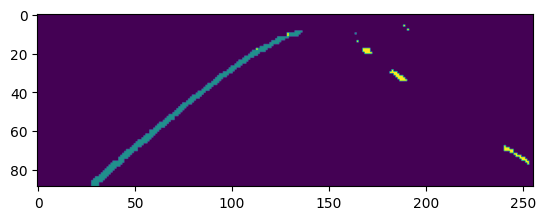

In [20]:
# Load an example image
test_path = path+"./test"
print(str((test_path)))
img = cv2.imread(str(get_image_files(test_path)[1]))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(img.shape)
print(str(get_image_files(test_path)[5]))
plt.imshow(np.array(learn.predict(img)[0]))

In [21]:
# Export the model if you have fine-tuned it
torch.save(model.state_dict(), '/content/drive/MyDrive/final_TRAINED_model.pth')

## Post training static quantization

In [22]:
import torch
import torch.nn as nn
import torch.ao.quantization

class QuantizedMobileV3SmallWithSoftmax(nn.Module):
    def __init__(self, num_classes=3, use_aspp=True, num_filters=64):
        super(QuantizedMobileV3SmallWithSoftmax, self).__init__()
        # Define quantization and dequantization stubs
        self.quant = torch.ao.quantization.QuantStub()
        self.dequant = torch.ao.quantization.DeQuantStub()

        # Define the main model
        self.model = MobileV3Small(num_classes=num_classes, use_aspp=use_aspp, num_filters=num_filters)

        # Define the softmax layer for the final output
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Quantize the input
        x = self.quant(x)

        # Pass through the main model
        x = self.model(x)

        # Dequantize the output
        x = self.dequant(x)

        # Apply softmax to the output
        x = self.softmax(x)

        return x


In [23]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp_delme.p")
    print('Size (KB):', os.path.getsize("temp_delme.p")/1e3)
    os.remove('temp_delme.p')


In [24]:
# Initialize the quantized model architecture
net_quantized = QuantizedMobileV3SmallWithSoftmax().to(device)

# Define the path to the pretrained model weights
model_path = '/content/drive/MyDrive/final_TRAINED_model.pth'

# Load the pretrained model weights
state_dict = torch.load(model_path, map_location='cpu')

# Load the state dictionary into the model with relaxed state dict checking
net_quantized.load_state_dict(state_dict, strict=False)

# Set the model to evaluation mode
net_quantized.eval()

QuantizedMobileV3SmallWithSoftmax(
  (quant): QuantStub()
  (dequant): DeQuantStub()
  (model): MobileV3Small(
    (trunk): MobileNetV3_Small(
      (early): Sequential(
        (0): Conv2dSame(
          3, 16, kernel_size=(3, 3), stride=(2, 2), bias=False
          (quant): QuantStub()
          (dequant): DeQuantStub()
        )
        (1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): HardSwishMe()
      )
      (block0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2dSame(
            16, 16, kernel_size=(3, 3), stride=(2, 2), groups=16, bias=False
            (quant): QuantStub()
            (dequant): DeQuantStub()
          )
          (bn1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (quant): QuantStub()
       

In [25]:
import torch
from torch.ao.quantization import default_qconfig, prepare

# Set quantization configuration for the model
net_quantized.qconfig = default_qconfig

# Disable quantization for specific parts of the model, if needed
net_quantized.softmax.qconfig = None  # Disable quantization for the softmax layer

# Insert observers for tracking statistics during calibration
net_quantized = prepare(net_quantized)

# Display the model with observers inserted
net_quantized


QuantizedMobileV3SmallWithSoftmax(
  (quant): QuantStub(
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (dequant): DeQuantStub()
  (model): MobileV3Small(
    (trunk): MobileNetV3_Small(
      (early): Sequential(
        (0): Conv2dSame(
          3, 16, kernel_size=(3, 3), stride=(2, 2), bias=False
          (quant): QuantStub(
            (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
          )
          (dequant): DeQuantStub()
        )
        (1): BatchNorm2d(
          16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
        )
        (2): HardSwishMe()
      )
      (block0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2dSame(
            16, 16, kernel_size=(3, 3), stride=(2, 2), groups=16, bias=False
            (quant): QuantStub(
              (activation_post_process): MinMaxObserver(min_val=

In [26]:
# Define the test data loaders
test_dls = SegmentationDataLoaders.from_label_func(
    path + '/test/', bs=2, fnames=fnames, label_func=label_func, codes=codes, valid_pct=0
)

# Define the learner with the quantized model
test_learn = Learner(
    dls=test_dls,
    model=net_quantized,
    metrics=[DiceMulti(), foreground_acc]
)

In [27]:
def test(test_learn):
    """
    Validate the model on test data loaders and extract metrics.

    Args:
        test_learn: Learner object containing the trained model and metrics.

    Returns:
        Tuple containing the first test set's DiceMulti and foreground accuracy metrics.
    """
    # Validate the model on each test data loader
    test_results = [test_learn.validate(dl=dataloader) for dataloader in test_dls]

    # Extract and store the metrics from the test results
    test_metrics = [
        (result[0], result[1])  # Assuming DiceMulti() metric is at index 0 and foreground_acc at index 1
        for result in test_results
    ]

    # Get the first set of metrics (modify if you need metrics for all datasets)
    dice_multi_metric, foreground_acc_metric = test_metrics[0]

    # Display the test metrics
    print(dice_multi_metric, foreground_acc_metric)

    # Return the metrics for further use
    return dice_multi_metric, foreground_acc_metric


In [28]:
# CALIBRATE
test(test_learn)

/usr/local/lib/python3.10/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


0.5692243576049805 0.6263309888805252


(0.5692243576049805, 0.6263309888805252)

In [29]:
net_quantized = test_learn.model
net_quantized =net_quantized.to("cpu")

In [30]:
net_quantized = torch.ao.quantization.convert(net_quantized)

/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/utils.py:339: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


In [31]:
print(f'Check statistics of the various layers')
net_quantized

Check statistics of the various layers


QuantizedMobileV3SmallWithSoftmax(
  (quant): Quantize(scale=tensor([0.0075]), zero_point=tensor([0]), dtype=torch.quint8)
  (dequant): DeQuantize()
  (model): MobileV3Small(
    (trunk): MobileNetV3_Small(
      (early): Sequential(
        (0): Conv2dSame(
          3, 16, kernel_size=(3, 3), stride=(2, 2), bias=False
          (quant): Quantize(scale=tensor([0.0767]), zero_point=tensor([64]), dtype=torch.quint8)
          (dequant): DeQuantize()
        )
        (1): QuantizedBatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): HardSwishMe()
      )
      (block0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2dSame(
            16, 16, kernel_size=(3, 3), stride=(2, 2), groups=16, bias=False
            (quant): Quantize(scale=tensor([4.0414]), zero_point=tensor([43]), dtype=torch.quint8)
            (dequant): DeQuantize()
          )
          (bn1): QuantizedBatchNorm2d(16, eps=0.001, momentum=0.1, affine=True

In [32]:
# print_size_of_model(model)
print_size_of_model(net_quantized)

Size (KB): 1490.708


/content/drive/MyDrive/lane_Data/./test
(89, 256, 3)
/content/drive/MyDrive/lane_Data/test/resized_Town04_Clear_Noon_09_09_2020_14_57_22_frame_1172_validation_set.png


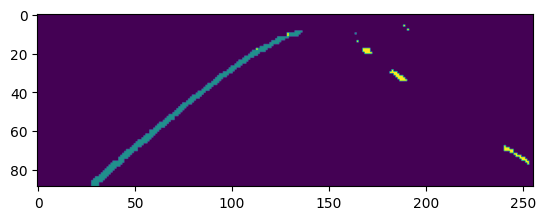

In [33]:
# Load an example image
test_path = path+"./test"
print(str((test_path)))
img = cv2.imread(str(get_image_files(test_path)[1]))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(img.shape)
print(str(get_image_files(test_path)[5]))
plt.imshow(np.array(test_learn.predict(img)[0]))

## Export Quantizied Model

In [34]:
torch.save(net_quantized.state_dict(), '/content/drive/MyDrive/final_quantized_model_2.pth')

## load and test Quantizied model


In [36]:
import torch
from torch.ao.quantization import default_qconfig, prepare, convert

# 1. Initialize quantized model
net_quantized = QuantizedMobileV3SmallWithSoftmax().to(device)
net_quantized.qconfig = default_qconfig
net_quantized.softmax.qconfig = None  # Disable quantization for softmax

# 2. Insert observers
net_quantized = prepare(net_quantized)

# 3. Apply quantization
net_quantized = convert(net_quantized)

# 4. Load trained quantized model
model_path = '/content/drive/MyDrive/final_quantized_model_2.pth'
state_dict = torch.load(model_path, map_location='cpu')
net_quantized.load_state_dict(state_dict, strict=False)
net_quantized.eval()

# Define test data loaders
test_dls = SegmentationDataLoaders.from_label_func(
    path + '/test/', bs=2, fnames=fnames, label_func=label_func, codes=codes, valid_pct=0
)

# Create Learner object for testing
test_learn = Learner(test_dls, net_quantized, metrics=[DiceMulti(), foreground_acc])


# PREDICT

/content/drive/MyDrive/lane_Data/./test
(89, 256, 3)
/content/drive/MyDrive/lane_Data/test/resized_Town04_Clear_Noon_09_09_2020_14_57_22_frame_1172_validation_set.png


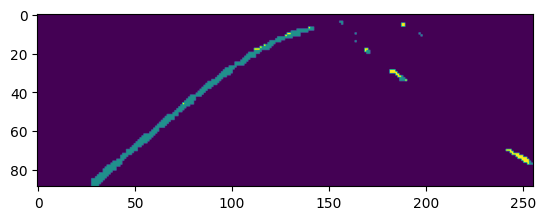

In [37]:
# Load an example image
test_path = path+"./test"
print(str((test_path)))
img = cv2.imread(str(get_image_files(test_path)[1]))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
print(img.shape)
print(str(get_image_files(test_path)[5]))
plt.imshow(np.array(test_learn.predict(img)[0]))

Original image shape: torch.Size([1, 3, 89, 256])


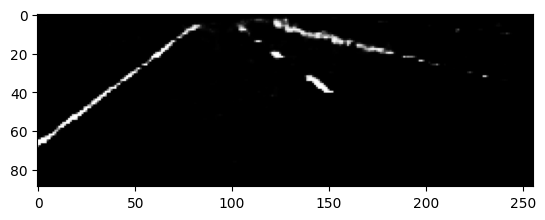

In [38]:
# predict using non quantized model
# Test with a sample
import cv2
from PIL import Image
import torch
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

img = cv2.imread('/content/drive/MyDrive/lane_Data/val/resized_Town04_Clear_Noon_09_09_2020_14_57_22_frame_0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_tensor = transforms.ToTensor()(img)
img_tensor = img_tensor.unsqueeze(0)
image = img_tensor.to('cpu')
print("Original image shape:", image.shape)


output = net_quantized(image)


output_channel_1 = output[0][1].cpu().detach().numpy()
output_channel_2 = output[0][2].cpu().detach().numpy()

concatenated_output = output_channel_1 + output_channel_2
plt.imshow(100*concatenated_output, cmap='gray')


# Export to ONNX

In [39]:
! pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 82.7 MB/s eta 0:00:00


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
import geffnet
import torch
from fastseg import MobileV3Small


geffnet.config.set_exportable(True)

net_quantized.to("cpu")
net_quantized.eval()

print('==> Exporting to ONNX')
height, width = [256,89]
print(f'Image dimensions: {height} x {width}')


dummy_input = torch.randn(1, 3, height, width).to("cpu")
input_names = ['input0']
output_names = ['output0']



# Run model once, this is required by geffnet
net_quantized(dummy_input)

torch.onnx.export(net_quantized, dummy_input, "/content/drive/MyDrive/final_QUanitzed_lane_seg_.onnx", verbose=True,
    input_names=input_names, output_names=output_names,
    opset_version=11, keep_initializers_as_inputs=True)


